In [30]:
import torch
from models.resnet50_cbam import build_resnet50_cbam

x = torch.randn(4, 3, 32, 32)
model = build_resnet50_cbam(num_classes=10, use_cbam=True, cifar_stem=True)
# model = build_resnet50_cbam(num_classes=10, use_cbam=False, cifar_stem=True)

model.eval()


ResNet50_CBAM(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BottleneckCBAM(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-

In [6]:
# Model summary via forward hooks (works for arbitrary nn.Module)
import torch
from collections import OrderedDict
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example input shape (adjust to your real input)
batch_size = 4
in_channels = 3
H = W = 32
x = torch.randn(batch_size, in_channels, H, W, device=device)

# Ensure `model` exists (import/build before running this cell)
model = model.to(device)
model.eval()

summary = OrderedDict()

# Hook fn that records output shape
def hook_fn(module, inp, out, name):
    # try to get the shape; handle tuples/lists/None
    try:
        if isinstance(out, (list, tuple)):
            out_shape = [tuple(o.shape) if hasattr(o, "shape") else str(type(o)) for o in out]
        elif out is None:
            out_shape = None
        else:
            out_shape = tuple(out.shape)
    except Exception:
        out_shape = str(type(out))
    # count parameters
    total_params = sum(p.numel() for p in module.parameters())
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    summary[name] = {
        "module": module.__class__.__name__,
        "output_shape": out_shape,
        "params": total_params,
        "trainable": trainable
    }

# Register hooks for all modules except the top-level module (we'll run model(x) anyway)
hooks = []
for name, module in model.named_modules():
    # skip registering hook on the overall model itself to avoid clutter
    if name == "":
        continue
    # register hook; use default closure to capture name
    hooks.append(module.register_forward_hook(lambda m, inp, out, nm=name: hook_fn(m, inp, out, nm)))

# Run a forward pass (hooks populate `summary`)
with torch.no_grad():
    out = model(x)

# remove hooks
for h in hooks:
    h.remove()

# Print nicely
lines = []
lines.append(f"{'Name':60} {'Type':25} {'Output Shape':30} {'Params':12} {'Trainable':12}")
lines.append("-"*150)
total_params = 0
total_trainable = 0
for name, info in summary.items():
    total_params += info["params"]
    total_trainable += info["trainable"]
    out_sh = info["output_shape"]
    out_sh_str = str(out_sh)
    lines.append(f"{name:60.60} {info['module']:25.25} {out_sh_str:30.30} {info['params']:12,d} {info['trainable']:12,d}")

lines.append("-"*150)
lines.append(f"{'Total':60} {'':25} {'':30} {total_params:12,d} {total_trainable:12,d}")

print("\n".join(lines))


Name                                                         Type                      Output Shape                   Params       Trainable   
------------------------------------------------------------------------------------------------------------------------------------------------------
conv1                                                        Conv2d                    (4, 64, 32, 32)                       1,728        1,728
bn1                                                          BatchNorm2d               (4, 64, 32, 32)                         128          128
relu                                                         ReLU                      (4, 64, 32, 32)                           0            0
maxpool                                                      Identity                  (4, 64, 32, 32)                           0            0
layer1.0.conv1                                               Conv2d                    (4, 64, 32, 32)                       4,09

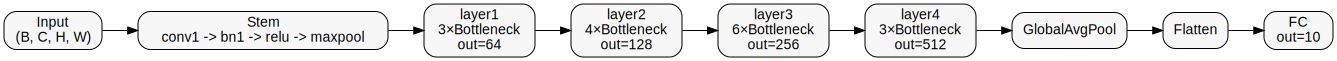

Saved compact diagram -> resnet50_cbam_compact.png


In [14]:
# Compact high-level DAG of model forward flow
# Requires graphviz Python package (not the same as system dot) but dot must be on PATH for rendering inline.
from graphviz import Digraph
import torch

def compact_model_graph(model):
    dot = Digraph(name="resnet_compact", format="png")
    dot.attr(rankdir="LR", fontsize="10")
    dot.attr('node', shape='box', style='rounded,filled', fillcolor='#f7f7f7', fontname='Helvetica')

    # helper to get layer info
    def layer_info(module):
        # count bottleneck blocks and out_channels if possible
        n_blocks = 0
        out_ch = None
        for m in module.children():
            n_blocks += 1
            # try to find conv3 out_channels in first block
            if out_ch is None:
                for sub in m.modules():
                    if isinstance(sub, torch.nn.Conv2d) and sub.kernel_size == (1,1):
                        out_ch = sub.out_channels
                        break
        return n_blocks, out_ch

    # top-level nodes
    dot.node("input", "Input\n(B, C, H, W)")
    dot.node("stem", "Stem\nconv1 -> bn1 -> relu -> maxpool")
    # layer nodes
    lnodes = []
    for name, child in model.named_children():
        if name.startswith("layer"):
            n_blocks, out_ch = layer_info(child)
            label = f"{name}\n{n_blocks}×Bottleneck\nout={out_ch}"
            dot.node(name, label)
            lnodes.append(name)
    dot.node("avgpool", "GlobalAvgPool")
    dot.node("flatten", "Flatten")
    dot.node("fc", f"FC\nout={getattr(model,'fc').out_features}")

    # edges in forward order
    dot.edge("input", "stem")
    prev = "stem"
    for ln in lnodes:
        dot.edge(prev, ln)
        prev = ln
    dot.edge(prev, "avgpool")
    dot.edge("avgpool", "flatten")
    dot.edge("flatten", "fc")

    return dot

# usage: ensure `model` exists in scope
model = model.to('cpu')
dot = compact_model_graph(model)
# render inline in notebook (or save as file)
display(dot)   # in Jupyter this will show the compact PNG/SVG
# or save file:
dot.render("resnet50_cbam_compact", cleanup=True)
print("Saved compact diagram -> resnet50_cbam_compact.png")


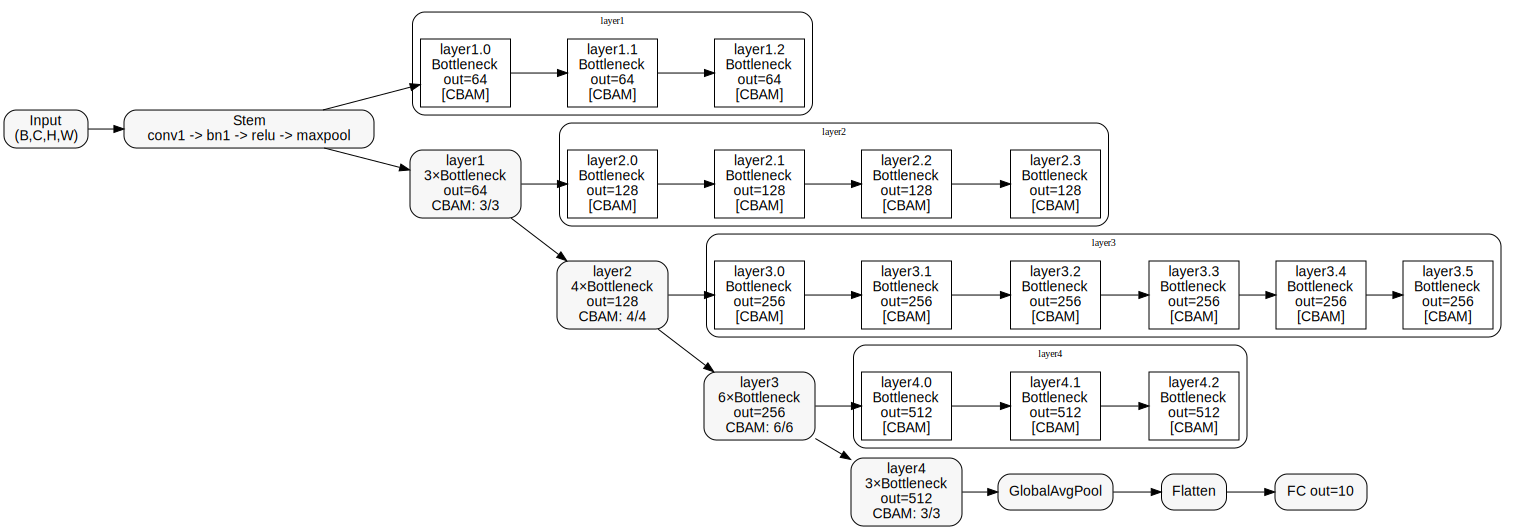

Saved -> resnet50_cbam_compact_with_cbam.png


In [31]:
# Compact graph showing Bottleneck blocks and CBAM
from graphviz import Digraph
import torch

def compact_graph_with_cbam(model):
    dot = Digraph(name="resnet_cbam_compact", format="png")
    dot.attr(rankdir="LR", fontsize="10")
    dot.attr('node', shape='box', style='rounded,filled', fillcolor='#f7f7f7', fontname='Helvetica')

    dot.node("input", "Input\n(B,C,H,W)")
    dot.node("stem", "Stem\nconv1 -> bn1 -> relu -> maxpool")

    # Helper to get info per layer: number of blocks and whether block has CBAM
    def layer_blocks_info(layer_module):
        info = []
        for idx, block in enumerate(layer_module.children()):
            # detect CBAM existence on block
            has_cbam = any(sub.__class__.__name__ == "CBAM" for sub in block.modules())
            # out channels: try conv3 out_channels if present
            out_ch = None
            for sub in block.modules():
                if isinstance(sub, torch.nn.Conv2d) and sub.kernel_size == (1,1):
                    out_ch = sub.out_channels
                    break
            info.append((idx, has_cbam, out_ch))
        return info

    # add nodes for each layer with compact labels
    layer_nodes = []
    for name, child in model.named_children():
        if name.startswith("layer"):
            blocks = layer_blocks_info(child)
            n_blocks = len(blocks)
            # compute annotation summarizing CBAM presence counts
            cbam_count = sum(1 for _,has_cbam,_ in blocks if has_cbam)
            out_ch = next((b[2] for b in blocks if b[2] is not None), None)
            label = f"{name}\n{n_blocks}×Bottleneck\nout={out_ch}\nCBAM: {cbam_count}/{n_blocks}"
            dot.node(name, label)
            layer_nodes.append((name, blocks))

    dot.node("avgpool", "GlobalAvgPool")
    dot.node("flatten", "Flatten")
    dot.node("fc", f"FC out={model.fc.out_features}")

    # build edges: stem -> layer1... -> avgpool -> flatten -> fc
    dot.edge("input", "stem")
    prev = "stem"
    for name, blocks in layer_nodes:
        dot.edge(prev, name)
        # Create a subgraph cluster for the layer to show block-level detail
        with dot.subgraph(name=f"cluster_{name}") as c:
            c.attr(label=name, style='rounded')
            for idx, has_cbam, out_ch in blocks:
                block_label = f"{name}.{idx}\nBottleneck\nout={out_ch}"
                if has_cbam:
                    block_label += "\n[CBAM]"
                node_name = f"{name}_{idx}"
                c.node(node_name, block_label, shape='box', style='filled', fillcolor='#ffffff')
                # connect previous to first block and chain blocks
                if idx == 0:
                    dot.edge(prev, node_name)
                else:
                    prev_block = f"{name}_{idx-1}"
                    dot.edge(prev_block, node_name)
        prev = name

    dot.edge(prev, "avgpool")
    dot.edge("avgpool", "flatten")
    dot.edge("flatten", "fc")
    return dot

# Usage (ensure model present)
model = model.to('cpu')
dot = compact_graph_with_cbam(model)
display(dot)           # show inline in notebook
dot.render("resnet50_cbam_compact_with_cbam", cleanup=True)
print("Saved -> resnet50_cbam_compact_with_cbam.png")


In [16]:
# Execution trace (filtered to include attention blocks)
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.randn(1, 3, 32, 32, device=device)
model = model.to(device)
model.eval()

call_list = []

def trace_hook(module, inp, out, name):
    # Try to get shape; handle lists/tuples
    try:
        out_shape = tuple(out.shape) if hasattr(out, "shape") else str(type(out))
    except Exception:
        out_shape = str(type(out))
    call_list.append((name, module.__class__.__name__, out_shape))

# We'll register hooks only for module classes we care about
interesting_classes = (
    getattr(model, "fc").__class__,  # Linear
    torch.nn.Conv2d,
    torch.nn.AdaptiveAvgPool2d,
    # include batchnorm if desired
    # torch.nn.BatchNorm2d,
)

# Add CBAM-related class types by name (in case classes are local)
# We'll detect by names for CBAM, ChannelAttention, SpatialAttention, BottleneckCBAM
hooks = []
for name, module in model.named_modules():
    if name == "":
        continue
    cls = module.__class__
    cls_name = cls.__name__
    # choose modules to hook: conv, pool, linear, bottleneck, CBAM and attention submodules
    if isinstance(module, interesting_classes) or cls_name in ("BottleneckCBAM", "CBAM", "ChannelAttention", "SpatialAttention"):
        hooks.append(module.register_forward_hook(lambda m, inp, out, nm=name: trace_hook(m, inp, out, nm)))

# run forward
with torch.no_grad():
    _ = model(x)

# remove hooks
for h in hooks:
    h.remove()

# print chronological trace
for i, (name, cls, shape) in enumerate(call_list):
    print(f"{i:03d}: {name:40.40} | {cls:20.20} | out {shape}")


Conv2d               (1, 64, 32, 32)
BatchNorm2d          (1, 64, 32, 32)
ReLU                 (1, 64, 32, 32)
Conv2d               (1, 64, 32, 32)
BatchNorm2d          (1, 64, 32, 32)
ReLU                 (1, 64, 32, 32)
Conv2d               (1, 64, 32, 32)
BatchNorm2d          (1, 64, 32, 32)
ReLU                 (1, 64, 32, 32)
Conv2d               (1, 256, 32, 32)
BatchNorm2d          (1, 256, 32, 32)
Conv2d               (1, 256, 32, 32)
BatchNorm2d          (1, 256, 32, 32)
Conv2d               (1, 16, 1, 1)
ReLU                 (1, 16, 1, 1)
Conv2d               (1, 256, 1, 1)
Conv2d               (1, 16, 1, 1)
ReLU                 (1, 16, 1, 1)
Conv2d               (1, 256, 1, 1)
Conv2d               (1, 1, 32, 32)
BatchNorm2d          (1, 1, 32, 32)
ReLU                 (1, 256, 32, 32)
BottleneckCBAM       (1, 256, 32, 32)
Conv2d               (1, 64, 32, 32)
BatchNorm2d          (1, 64, 32, 32)
ReLU                 (1, 64, 32, 32)
Conv2d               (1, 64, 32, 32)
BatchNo

In [24]:
inp = inp.to(device)  # ensure input is on the same device

In [27]:
b = dict(model.named_modules())['layer2.1']  # BottleneckCBAM
print("Bottleneck class:", b.__class__.__name__)
print("Has attribute use_cbam:", getattr(b, "use_cbam", False))
print("Has cbam module:", hasattr(b, "cbam"))
# run forward on a single sample and inspect shapes
with torch.no_grad():
    inp = torch.randn(1, 512, 16, 16)  # adapt shape to that block's expected input
    out = b.to("cpu")(inp.to("cpu"))   # will run convs, residual add, cbam, relu
    print("block output shape:", out.shape)


Bottleneck class: BottleneckCBAM
Has attribute use_cbam: True
Has cbam module: True
Conv2d               (1, 128, 16, 16)
BatchNorm2d          (1, 128, 16, 16)
ReLU                 (1, 128, 16, 16)
Conv2d               (1, 128, 16, 16)
BatchNorm2d          (1, 128, 16, 16)
ReLU                 (1, 128, 16, 16)
Conv2d               (1, 512, 16, 16)
BatchNorm2d          (1, 512, 16, 16)
Conv2d               (1, 32, 1, 1)
ReLU                 (1, 32, 1, 1)
Conv2d               (1, 512, 1, 1)
Conv2d               (1, 32, 1, 1)
ReLU                 (1, 32, 1, 1)
Conv2d               (1, 512, 1, 1)
Conv2d               (1, 1, 16, 16)
BatchNorm2d          (1, 1, 16, 16)
ReLU                 (1, 512, 16, 16)
BottleneckCBAM       (1, 512, 16, 16)
block output shape: torch.Size([1, 512, 16, 16])


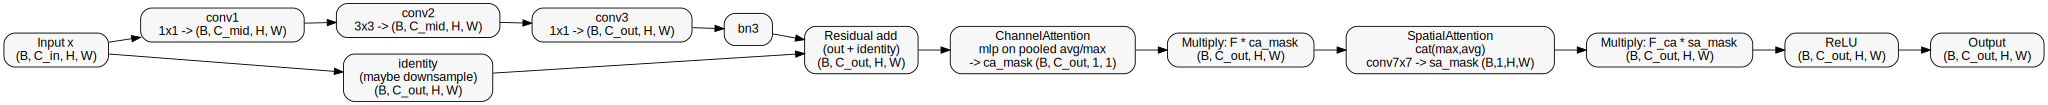

Saved bottleneck_cbam_single.png


: 

In [ ]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='LR', fontsize='10')
# set default node attributes correctly:
dot.attr('node', shape='box', style='rounded,filled', fillcolor='#f7f7f7', fontname='Helvetica')

dot.node('x', 'Input x\n(B, C_in, H, W)')

# main conv path
dot.node('c1', 'conv1\n1x1 -> (B, C_mid, H, W)')
dot.node('c2', 'conv2\n3x3 -> (B, C_mid, H, W)')
dot.node('c3', 'conv3\n1x1 -> (B, C_out, H, W)')
dot.node('bn3', 'bn3')
dot.node('add', 'Residual add\n(out + identity)\n(B, C_out, H, W)')

# CBAM nodes
dot.node('ca', 'ChannelAttention\nmlp on pooled avg/max\n-> ca_mask (B, C_out, 1, 1)')
dot.node('mul_ca', 'Multiply: F * ca_mask\n(B, C_out, H, W)')
dot.node('sa', 'SpatialAttention\ncat(max,avg)\nconv7x7 -> sa_mask (B,1,H,W)')
dot.node('mul_sa', 'Multiply: F_ca * sa_mask\n(B, C_out, H, W)')

dot.node('relu', 'ReLU\n(B, C_out, H, W)')
dot.node('out', 'Output\n(B, C_out, H, W)')

# identity path
dot.node('id', 'identity\n(maybe downsample)\n(B, C_out, H, W)')

# connect main path
dot.edge('x', 'c1')
dot.edge('c1', 'c2')
dot.edge('c2', 'c3')
dot.edge('c3', 'bn3')

# connect residual
dot.edge('x', 'id')
dot.edge('bn3', 'add')
dot.edge('id', 'add')

# connect CBAM and rest
dot.edge('add', 'ca')
dot.edge('ca', 'mul_ca')
dot.edge('mul_ca', 'sa')
dot.edge('sa', 'mul_sa')
dot.edge('mul_sa', 'relu')
dot.edge('relu', 'out')

# render & display (in Jupyter this should show inline)
display(dot)
dot.render('bottleneck_cbam_single', cleanup=True)
print("Saved bottleneck_cbam_single.png")
